## CASMI 2022 evaluation

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from mist_cf import common, decomp
from rdkit import Chem
from rdkit.Chem import Draw
from mist_cf.common.plot_utils import *

set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fig_folder = Path("../results/figures/")
fig_folder = fig_folder / "casmi22"
fig_folder.mkdir(parents=True, exist_ok=True)

# mdkir
fig_folder.mkdir(parents=True, exist_ok=True)
data_folder = Path("../data/casmi22/")
# rdbe_labels_file = data_folder / "decoy_labels/decoy_label_RDBE.tsv"
labels_file = data_folder / "CASMI_labels.tsv"
labels = pd.read_csv(labels_file, sep="\t")

## Compute the fraction that we could recover with our el decomp

In [3]:
forms = labels["formula"]
vecs = [common.formula_to_dense(i) for i in forms]
vecs = np.array(vecs)

# Get max formula
max_form_vals = decomp.sirius_decomp.parse_element_str(
    decomp.sirius_decomp.EL_STR_DEFAULT
)
print(decomp.sirius_decomp.EL_STR_DEFAULT)
max_form_vals = {k: v["max"] for k, v in max_form_vals.items()}
max_form = "".join([k + str(v) for k, v in max_form_vals.items()])
max_form_vec = common.formula_to_dense(max_form)
num_findable = (vecs <= max_form_vec).all(axis=1).sum()
print(f"Num findable: {num_findable}")
print(f"Frac findable: {num_findable / len(vecs):.2f}")

C[0-]N[0-]O[0-]H[0-]S[0-5]P[0-3]I[0-1]Cl[0-1]F[0-1]Br[0-1]
Num findable: 296
Frac findable: 0.97


In [4]:
max_form_vals

{'C': 999,
 'N': 999,
 'O': 999,
 'H': 999,
 'S': 5,
 'P': 3,
 'I': 1,
 'Cl': 1,
 'F': 1,
 'Br': 1}

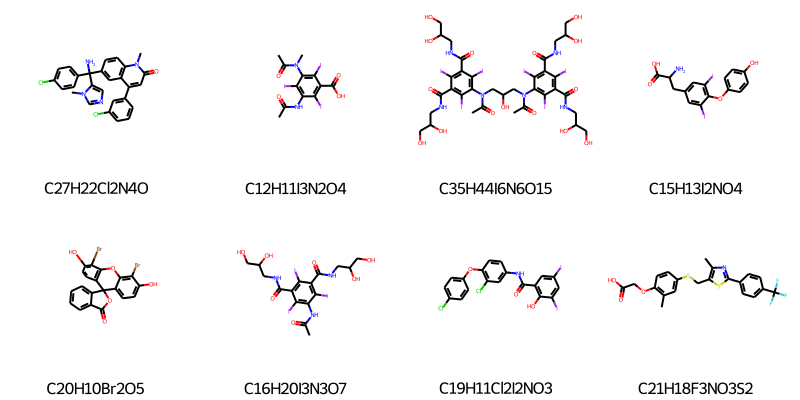

In [5]:
# Example failed molecules
failed_inds = ~(vecs <= max_form_vec).all(axis=1)
failed_rows = labels[failed_inds]
failed_smis = failed_rows["smiles"]
failed_forms = failed_rows["formula"]
# Randomly sample 10 smiles, convert to rd mols then draw with formual underneath in a grid
sample_num = min(10, len(failed_smis))
failed_smis = failed_smis.sample(sample_num)
failed_forms = [str(i) for i in failed_forms.loc[failed_smis.index]]
failed_mols = [Chem.MolFromSmiles(i) for i in failed_smis.values]

# Draw
Draw.MolsToGridImage(
    failed_mols,
    molsPerRow=min(4, sample_num),
    subImgSize=(200, 200),
    legends=failed_forms,
)

## Load results

In [6]:
res_folders = {
    "mist_cf_ms2_50_peaks": ["../results/mist_cf_predict_casmi22/"],
    "mist_cf_ms2": ["../results/mist_cf_predict_casmi22_50_peaks"],
    "sirius": ["../results/sirius_predict_casmi22/sirius_1"],
    "sirius_struct": ["../results/sirius_predict_casmi22/sirius_1_structure"],
    "sirius_submit": ["../results/sirius_predict_casmi22/sirius_submission"],
}

In [7]:
dict_list = [
    {"model": model_name, "folder": f}
    for model_name, folder_list in res_folders.items()
    for f in folder_list
]

In [8]:
all_dfs = []
formatted_outs = []
for entry in dict_list:
    folder = Path(entry["folder"])
    model = entry["model"]
    # load results
    print(entry)
    res_files = folder.rglob("full_out.tsv")
    for res_file in res_files:
        split = res_file.parent.parent.name
        df = pd.read_csv(res_file, sep="\t")
        df["split"] = split
        df["model"] = model
        all_dfs.append(df)
    res_files = folder.rglob("formatted_output.tsv")
    for res_file in res_files:
        split = res_file.parent.parent.name
        df = pd.read_csv(res_file, sep="\t")
        df["split"] = split
        df["model"] = model
        formatted_outs.append(df)
all_df = pd.concat(all_dfs, ignore_index=True)
formatted_outs = pd.concat(formatted_outs, ignore_index=True)

{'model': 'mist_cf_ms2_50_peaks', 'folder': '../results/mist_cf_predict_casmi22/'}
{'model': 'mist_cf_ms2', 'folder': '../results/mist_cf_predict_casmi22_50_peaks'}
{'model': 'sirius', 'folder': '../results/sirius_predict_casmi22/sirius_1'}
{'model': 'sirius_struct', 'folder': '../results/sirius_predict_casmi22/sirius_1_structure'}
{'model': 'sirius_submit', 'folder': '../results/sirius_predict_casmi22/sirius_submission'}


## Convert results to Top K accuracy tables

In [9]:
# Group by method, split, and compute top k accuracy through 20

denom = len(labels)


def top_k_accuracy(x, top_k, key_str="ind_found"):
    k_dict = []
    for k in top_k:
        acc = np.sum(x[key_str] <= k) / denom
        k_dict.append({"k": k, "acc": acc})
    return k_dict


top_k = [1]
# top_k_acc = all_df.groupby(["model", "split",]).apply(lambda x: top_k_accuracy(x, top_k))

keys = ["model", "split"]  # , "mass_bin"]
key_strs = ["ind_found", "ind_found_adduct", "ind_found_full_form"]
out_df = []
for names, sub_df in all_df.groupby(keys):
    update_dict = dict(zip(keys, names))
    for key_str in key_strs:
        sub_dicts = top_k_accuracy(sub_df, top_k, key_str=key_str)

        out_df.extend([dict(**i, **update_dict, val=key_str) for i in sub_dicts])
    num_submitted = int(len(sub_df))
    out_df.append(
        dict(k="num_submitted", val="num_submitted", acc=num_submitted, **update_dict)
    )
print(out_df)
out_df = pd.DataFrame(out_df)

[{'k': 1, 'acc': 0.8421052631578947, 'model': 'mist_cf_ms2', 'split': 'mist_cf_predict_casmi22_50_peaks', 'val': 'ind_found'}, {'k': 1, 'acc': 0.9013157894736842, 'model': 'mist_cf_ms2', 'split': 'mist_cf_predict_casmi22_50_peaks', 'val': 'ind_found_adduct'}, {'k': 1, 'acc': 0.8618421052631579, 'model': 'mist_cf_ms2', 'split': 'mist_cf_predict_casmi22_50_peaks', 'val': 'ind_found_full_form'}, {'k': 'num_submitted', 'val': 'num_submitted', 'acc': 304, 'model': 'mist_cf_ms2', 'split': 'mist_cf_predict_casmi22_50_peaks'}, {'k': 1, 'acc': 0.8223684210526315, 'model': 'mist_cf_ms2_50_peaks', 'split': 'mist_cf_predict_casmi22', 'val': 'ind_found'}, {'k': 1, 'acc': 0.8848684210526315, 'model': 'mist_cf_ms2_50_peaks', 'split': 'mist_cf_predict_casmi22', 'val': 'ind_found_adduct'}, {'k': 1, 'acc': 0.868421052631579, 'model': 'mist_cf_ms2_50_peaks', 'split': 'mist_cf_predict_casmi22', 'val': 'ind_found_full_form'}, {'k': 'num_submitted', 'val': 'num_submitted', 'acc': 304, 'model': 'mist_cf_ms2_

In [10]:
col_rename = {
    "ind_found": "Accuracy (formula)",
    "ind_found_adduct": "Accuracy (adduct)",
    "ind_found_full_form": "Accuracy (formula + adduct)",
}

In [11]:
# Pivot to have model and split as rows and k and val as columns, with acc as the values
tbl = out_df.pivot_table(index=["model"], columns=["val"], values="acc")
# Reorder rows
tbl = tbl.loc[sirius_order]
# Rename columns
tbl = tbl.rename(columns=col_rename, index=rename_scheme)
# Remove col title
tbl.columns.name = None
# Remove model index name
tbl.index.name = None
# Make only 3 decimal places
tbl = tbl.round(3)
tbl["num_submitted"] = tbl["num_submitted"].astype(int)
# Rename num submitted to "Num. submitted"
tbl = tbl.rename(columns={"num_submitted": "Num. predicted"})
display(tbl)

,Accuracy (formula),Accuracy (adduct),Accuracy (formula + adduct),Num. predicted
SIRIUS,0.109,0.161,0.641,274
SIRIUS (CSI:FingerID),0.516,0.543,0.678,254
SIRIUS (Curated),0.865,0.855,0.868,272
MIST-CF,0.842,0.901,0.862,304
MIST-CF (50 peaks),0.822,0.885,0.868,304


In [12]:
0.868 - 0.678

0.18999999999999995

In [13]:
latex = tbl.to_latex(
    caption="CASMI2022 model accuracy.", label="tab:casmi22_acc", escape=False
)
print(latex)

\begin{table}
\centering
\caption{CASMI2022 model accuracy.}
\label{tab:casmi22_acc}
\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy (formula) &  Accuracy (adduct) &  Accuracy (formula + adduct) &  Num. predicted \\
\midrule
SIRIUS                &               0.109 &              0.161 &                        0.641 &             274 \\
SIRIUS (CSI:FingerID) &               0.516 &              0.543 &                        0.678 &             254 \\
SIRIUS (Curated)      &               0.865 &              0.855 &                        0.868 &             272 \\
MIST-CF               &               0.842 &              0.901 &                        0.862 &             304 \\
MIST-CF (50 peaks)    &               0.822 &              0.885 &                        0.868 &             304 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_9531/1790121275.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = tbl.to_latex(


## Analysis of comparative results

In [60]:
all_df['model'].unique()

array(['mist_cf_ms2_50_peaks', 'mist_cf_ms2', 'sirius', 'sirius_struct',
       'sirius_submit'], dtype=object)

In [66]:
compare_methods = ["mist_cf_ms2", "sirius_submit"]
method_1 = compare_methods[0]
method_2 = compare_methods[1]

# filter all df
all_df_compare = all_df[all_df["model"].isin(compare_methods)]

# all_df_compare.keys()
keep_keys = ['spec', 'ind_found', 'ind_found_adduct', 'ind_found_full_form', 'mass',
'mass_bin', 'true_form', 'true_ion','model']
all_df_compare = all_df_compare[keep_keys]

compare_key = "ind_found_full_form"
compare_key = "ind_found_full_form"

# Find all entries where method_1 == 1 and method 2 >1
method_1_acc = dict(all_df_compare[all_df_compare["model"] == method_1][["spec", compare_key,]].values)
method_2_acc = dict(all_df_compare[all_df_compare["model"] == method_2][["spec", compare_key,]].values)

method_1_acc_ct = {k: v for k, v in method_1_acc.items() if v == 1 and method_2_acc.get(k, 100) > 1}
method_2_acc_ct = {k: v for k, v in method_2_acc.items() if v == 1 and method_1_acc.get(k, 100) > 1}
agree_top1 = {k: v for k, v in method_2_acc.items() if v == 1 and method_1_acc.get(k, 100) == 1}

# Print
print(f"{method_1}: {len(method_1_acc_ct)}")
print(f"{method_2}: {len(method_2_acc_ct)}")
print(f"Agree: {len(agree_top1)}")

mist_cf_ms2: 32
sirius_submit: 34
Agree: 230


In [68]:
method_1_better = list(method_1_acc_ct.keys())
method_2_better = list(method_2_acc_ct.keys())

In [69]:
spec_keys = ['spec','mass_bin', 'true_form', 'true_ion']
# Get unique rows
all_df[spec_keys].set_index("spec").loc[method_1_better].drop_duplicates()

# Print number that were predicted by method_2
np.sum([i in method_2_acc for i in method_1_better])

7

In [70]:
spec_keys = ['spec','mass_bin', 'true_form', 'true_ion']
# Get unique rows
all_df[spec_keys].set_index("spec").loc[method_2_better].drop_duplicates()

# Print number that weren't predicted by method_1
np.sum([i not in method_1_acc for i in method_2_better])

0